## 1 Installations, imports et chargement

In [1]:
# === 📦 Imports nécessaires pour l'extraction de features textuelles ===

# 🧮 Données
import pandas as pd
import numpy as np

# 🛠️ Utilitaires
import re
import os
from tqdm import tqdm
tqdm.pandas()
from collections import defaultdict, Counter

# 📚 NLP : spaCy & NLTK
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# 🤗 BERT tokenizer (pour reconstruction des wordpieces)
from transformers import AutoTokenizer



# === ⚙️ Configuration générale ===

# Chemins
MODEL_DIR = "models/"
FIGURE_DIR = "figures/"

# Données
TEXT_COL = "text"
LABEL_COL = "label"

# NLP
LANGUAGE = "en"
STOPWORDS_LANGUAGE = "english"
BERT_MODEL_NAME = "bert-base-uncased"

# Chargement des ressources NLP
stop_en = set(stopwords.words(STOPWORDS_LANGUAGE))
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

# Options pandas (confort de lecture)
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", None)


[nltk_data] Downloading package stopwords to C:\Users\Julien
[nltk_data]     Rouillard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Julien Rouillard\anaconda3\envs\ia_detector_api_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
#Chemins d’accès
DATASET_PATH = "../datasets_source/Compilation_from_Kaggle_IA_Human.csv"
df = pd.read_csv(DATASET_PATH)

In [3]:
# Chaque texte -> liste de wordpieces (avec les sous-mots préfixés par ##)
df["bert_wp"] = df[TEXT_COL].astype(str).apply(tokenizer.tokenize)
df["bert_wp_len"] = df["bert_wp"].apply(len)

# (Option) IDs token + [CLS]/[SEP] (en prevision du modèle ensuite)
df["bert_ids"] = df[TEXT_COL].astype(str).apply(lambda t: tokenizer.encode(t, add_special_tokens=True))
df["bert_ids_len"] = df["bert_ids"].apply(len)

# Aperçu
df[[TEXT_COL, "bert_wp"]].head()

Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors


,text,bert_wp
0,It always seems impossible until it's done.,"[it, always, seems, impossible, until, it, ', s, done, .]"
1,She finished the challenging crossword puzzle.,"[she, finished, the, challenging, cross, ##word, puzzle, .]"
2,"You can't use up creativity. The more you use, the more you have.","[you, can, ', t, use, up, creativity, ., the, more, you, use, ,, the, more, you, have, .]"
3,The journey of a thousand miles begins with a single step.,"[the, journey, of, a, thousand, miles, begins, with, a, single, step, .]"
4,"Life is short, and it is up to you to make it sweet.","[life, is, short, ,, and, it, is, up, to, you, to, make, it, sweet, .]"


In [4]:
def reconstruct_words(wp_tokens):
    words = []
    current = ""
    for tok in wp_tokens:
        if tok.startswith("##"):
            current += tok[2:]
        else:
            if current:
                words.append(current)
            current = tok
    if current:
        words.append(current)
    return words

# Créer une colonne "bert_words" (mots reconstruits)
df["bert_words"] = df["bert_wp"].apply(reconstruct_words)
df["bert_words_len"] = df["bert_words"].apply(len)

# Aperçu
df[[TEXT_COL, "bert_wp", "bert_words"]].head()

,text,bert_wp,bert_words
0,It always seems impossible until it's done.,"[it, always, seems, impossible, until, it, ', s, done, .]","[it, always, seems, impossible, until, it, ', s, done, .]"
1,She finished the challenging crossword puzzle.,"[she, finished, the, challenging, cross, ##word, puzzle, .]","[she, finished, the, challenging, crossword, puzzle, .]"
2,"You can't use up creativity. The more you use, the more you have.","[you, can, ', t, use, up, creativity, ., the, more, you, use, ,, the, more, you, have, .]","[you, can, ', t, use, up, creativity, ., the, more, you, use, ,, the, more, you, have, .]"
3,The journey of a thousand miles begins with a single step.,"[the, journey, of, a, thousand, miles, begins, with, a, single, step, .]","[the, journey, of, a, thousand, miles, begins, with, a, single, step, .]"
4,"Life is short, and it is up to you to make it sweet.","[life, is, short, ,, and, it, is, up, to, you, to, make, it, sweet, .]","[life, is, short, ,, and, it, is, up, to, you, to, make, it, sweet, .]"


In [5]:
#Version "ponctuation conservée" pour l'analyse de style

def normalize_keep_punct(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_norm"] = df[TEXT_COL].astype(str).apply(normalize_keep_punct)

# Verification nettoyage est bien fait
print(df[[TEXT_COL, "bert_words", "label"]].head())

                                                                text  \
0                        It always seems impossible until it's done.   
1                     She finished the challenging crossword puzzle.   
2  You can't use up creativity. The more you use, the more you have.   
3         The journey of a thousand miles begins with a single step.   
4               Life is short, and it is up to you to make it sweet.   

                                                                                  bert_words  \
0                                  [it, always, seems, impossible, until, it, ', s, done, .]   
1                                    [she, finished, the, challenging, crossword, puzzle, .]   
2  [you, can, ', t, use, up, creativity, ., the, more, you, use, ,, the, more, you, have, .]   
3                   [the, journey, of, a, thousand, miles, begins, with, a, single, step, .]   
4                     [life, is, short, ,, and, it, is, up, to, you, to, make, it, swee

Longueur des textes

# 2 Rejet du fichier selon differents criteres et preprocessing si necessaire

In [6]:
# POUR L'API.

# 3 Extraction des features

In [7]:
import time

# Log des temps
execution_log = []

def log_time(step_name, start_time, end_time):
    duration = round(end_time - start_time, 2)
    execution_log.append({"Étape": step_name, "Durée (s)": duration})


## 3.1 Feature Longueur des elements: Phrases, mots, caracteres

In [8]:
"""Charger spaCy avec juste le parser (pour détecter les phrases)"""
nlp = spacy.load("en_core_web_sm", disable=["ner", "lemmatizer", "tagger"])

# Fonction pour identifier les "vrais mots"
def is_word_token(tok):
    return tok.is_alpha or tok.like_num or tok.like_url

texts = df["text"].astype(str).tolist()

# Initialiser les listes pour les résultats
len_chars_list = []
len_tokens_all_list = []
len_words_list = []
n_sentences_list = []
avg_sentence_length_list = []

for doc in nlp.pipe(texts, batch_size=256):
    tokens = list(doc)

    # Calculs de base
    len_chars_list.append(len(doc.text))
    len_tokens_all_list.append(len(tokens))
    len_words = sum(is_word_token(tok) for tok in tokens)
    len_words_list.append(len_words)

    # Analyse des phrases
    sentences = list(doc.sents)
    n_sentences = len(sentences)
    n_sentences_list.append(n_sentences)

    avg_len = (
        sum(len([t for t in sent if not t.is_space]) for sent in sentences) / n_sentences
        if n_sentences > 0 else 0
    )
    avg_sentence_length_list.append(avg_len)

# Création des colonnes dans le DataFrame, avec sécurité pour éviter division par zéro
df["len_chars"] = len_chars_list
df["len_tokens_all"] = len_tokens_all_list
df["len_words"] = pd.Series(len_words_list).clip(lower=1)
df["n_sentences"] = n_sentences_list
df["average_sentences_length"] = avg_sentence_length_list

# Calcul des ratios utiles
df["len_chars_per_word"] = df["len_chars"] / df["len_words"]
df["len_tokens_per_word"] = df["len_tokens_all"] / df["len_words"]

# Vérification rapide
print(df[["len_words", "n_sentences", "average_sentences_length", "len_chars_per_word", "len_tokens_per_word"]].head())

   len_words  n_sentences  average_sentences_length  len_chars_per_word  \
0          7            1                       9.0            6.142857   
1          6            1                       7.0            7.666667   
2         13            2                       8.5            5.000000   
3         11            1                      12.0            5.272727   
4         13            1                      15.0            4.000000   

   len_tokens_per_word  
0             1.285714  
1             1.166667  
2             1.307692  
3             1.090909  
4             1.153846  


In [9]:
t0 = time.time()

# Deja charger spaCy en désactivant les parties inutiles (parser,  ner) mais tagger oui



# Exemple de DataFrame
# df = pd.DataFrame({"text": ["This is a sentence.", "Another one here."]})

# Fonction pour détecter les mots "valides"
def _is_word_tok(tok):
    return tok.is_alpha or tok.like_num or tok.like_url

# Traitement
texts = df["text"].astype(str).tolist()

len_chars_list = []
len_tokens_all_list = []
len_words_list = []

for doc in nlp.pipe(texts, batch_size=256):
    toks = list(doc)
    len_chars_list.append(len(doc.text))
    len_tokens_all_list.append(len(toks))
    len_words_list.append(sum(1 for t in toks if _is_word_tok(t)))

# Séries alignées
len_chars_series = pd.Series(len_chars_list, index=df.index)
len_tokens_all_series = pd.Series(len_tokens_all_list, index=df.index)
len_words_series = pd.Series(len_words_list, index=df.index)

# Dénominateur sûr
denominator = len_words_series.replace(0, 1).fillna(1)

# Ratios
df["len_chars_per_word"] = len_chars_series / denominator
df["len_tokens_per_word"] = len_tokens_all_series / denominator
df["len_words"] = len_words_series

t1 = time.time()
log_time("Longeur des éléments", t0, t1)

## 3.2 Feature Ratio Majuscules

In [10]:
def extract_uppercase_ratio(df, text_col="text"):
    """
    Ajoute une colonne 'freq_uppercase' avec la fréquence de majuscules dans chaque texte.
    """
    df = df.copy()

    # Nombre de majuscules par texte
    nb_uppercase = df[text_col].astype(str).apply(lambda x: sum(1 for c in x if c.isupper()))

    # Longueur du texte (avec protection contre division par zéro)
    len_text = df[text_col].astype(str).apply(len).replace(0, 1)

    # Ratio majuscules / longueur
    df["freq_uppercase"] = nb_uppercase / len_text

    return df

t2 = time.time()
log_time("Ration Majuscules", t1, t2)

## 3.3 Feature Ponctuation

In [13]:
PUNCT_LIST = ['!', '?', ',', '.', ';', ':', '"', "'", '(']
ELLIPSIS_TOKEN = '...'

def _punctuation_features(text, len_words_value):
    text = text or ""
    res = {}
    ellipses = text.count(ELLIPSIS_TOKEN)
    text_wo_ell = text.replace(ELLIPSIS_TOKEN, "")
    denominator = max(len_words_value, 1)
    res['punct_ellipsis_ratio'] = ellipses / denominator
    for p in PUNCT_LIST:
        punct_name = re.sub(r'\W', '_', p)
        key = f"punct_{punct_name}_ratio"
        count = text_wo_ell.count(p)
        res[key] = count / denominator
    return res

len_words = df["len_words"].fillna(1).replace(0, 1).to_list()
texts = df['text'].astype(str).tolist()

punct_features = [_punctuation_features(text, lw) for text, lw in zip(texts, len_words)]

punct_df = pd.DataFrame(punct_features)

df = pd.concat([df.reset_index(drop=True), punct_df.reset_index(drop=True)], axis=1)

t3 = time.time()
log_time("Ponctuation", t2, t3)


## 3.4 StopWords (ratio)

In [14]:

def extract_stopwords_ratio(df, text_col="text", language="english"):
    """
    Calcule le ratio de stopwords parmi les tokens 'valide' (alpha, nombre ou URL),
    sans dépendre de colonnes préexistantes comme 'bert_words'.
    """

    df = df.copy()
    stop_words = set(stopwords.words(language))

    texts = df[text_col].astype(str).tolist()
    stopword_counts = []
    valid_word_counts = []

    for doc in nlp.pipe(texts, batch_size=256):
        toks = list(doc)
        valid_words = [tok for tok in toks if _is_word_tok(tok)]
        valid_word_counts.append(len(valid_words))
        stopword_counts.append(sum(1 for tok in valid_words if tok.text.lower() in stop_words))

    # Calcul du ratio
    denominator = pd.Series(valid_word_counts).replace(0, 1)  # éviter division par 0
    df["stopwords_ratio"] = pd.Series(stopword_counts) / denominator

    return df

df = extract_stopwords_ratio(df, text_col="text", language=STOPWORDS_LANGUAGE)


##########################################################################
##########################################################################
##########################################################################
# Ceci est nouveau, ces colonnes n'etaient pas integrees jusqu'a present
##########################################################################
##########################################################################
#df['bert_words'] = df[TEXT_COL].astype(str).apply(lambda x: tokenizer.tokenize(x))
#df['bert_words_len'] = df['bert_words'].apply(len)

#df = extract_stopwords_ratio(df, words_col="bert_words", words_len_col="bert_words_len", language=STOPWORDS_LANGUAGE)

t4 = time.time()
log_time("Ration Majuscules", t3, t4)



## 5.6 Feature Connecteurs logiques - A retirer selon moi

In [15]:


# Tokenisation simple pour 'bert_words'
#df["bert_words"] = df["text"].str.lower().str.split()
#df["len_words"] = df["bert_words"].apply(len).clip(lower=1)

# Définition du dictionnaire
connectives = {
    'addition': {'and', 'also', 'furthermore', 'moreover', 'in addition', 'besides', 'as well', 'what is more',
                 'not only... but also', 'similarly', 'likewise'},
    'contrast': {'but', 'however', 'on the other hand', 'nevertheless', 'nonetheless', 'yet', 'still',
                 'even so', 'although', 'though', 'whereas', 'while', 'in contrast', 'conversely'},
    'cause': {'because', 'since', 'as', 'due to', 'owing to', 'thanks to', 'considering that', 'for the reason that'},
    'consequence': {'so', 'therefore', 'thus', 'hence', 'as a result', 'consequently', 'accordingly', 'for this reason'},
    'concession': {'although', 'even though', 'though', 'while', 'granted that', 'admittedly', 'it is true that', 'nonetheless'},
    'example': {'for example', 'for instance', 'such as', 'like', 'to illustrate', 'namely', 'including', 'in particular'},
    'purpose': {'so that', 'in order to', 'in order that', 'so as to', 'to', 'for the purpose of', 'with the aim of'},
    'time': {'first', 'then', 'next', 'after that', 'afterwards', 'before', 'finally', 'meanwhile',
             'eventually', 'at the same time', 'subsequently'},
    'summary': {'in conclusion', 'to conclude', 'in summary', 'to sum up', 'overall', 'in short', 'all in all', 'ultimately'}
}


# Fonctions

def detect_connectives(words, connectives_dict):
    detected = defaultdict(list)
    text = ' '.join(words).lower()
    for category, phrases in connectives_dict.items():
        for phrase in phrases:
            if phrase in text:
                detected[category].append(phrase)
    return dict(detected)

def flatten_categories(d):
    return Counter({cat: len(lst) for cat, lst in d.items()})

def detect_connectives_spacy(text, connectives_dict):
    doc = nlp(text.lower())
    words = [tok.text for tok in doc if _is_word_tok(tok)]
    return detect_connectives(words, connectives_dict)

# --- Application
df["connectives_detected"] = df["text"].astype(str).apply(lambda t: detect_connectives_spacy(t, connectives))
df["connective_counts"] = df["connectives_detected"].apply(flatten_categories)


# Ratios
connective_categories = list(connectives.keys())
for cat in connective_categories:
    df[f"connective_{cat}_ratio"] = df["connective_counts"].apply(lambda c: c.get(cat, 0)) / df["len_words"]

# Résultat
cols = [col for col in df.columns if col.startswith("connective_") and col.endswith("_ratio")]
print(df[cols])

t5 = time.time()
log_time("Ration Majuscules", t4, t5)


       connective_addition_ratio  connective_contrast_ratio  \
0                       0.000000                        0.0   
1                       0.000000                        0.0   
2                       0.000000                        0.0   
3                       0.090909                        0.0   
4                       0.076923                        0.0   
...                          ...                        ...   
16188                   0.000000                        0.0   
16189                   0.000000                        0.0   
16190                   0.000000                        0.0   
16191                   0.000000                        0.0   
16192                   0.000000                        0.0   

       connective_cause_ratio  connective_consequence_ratio  \
0                    0.000000                      0.000000   
1                    0.000000                      0.000000   
2                    0.000000                      0.0

## 5.7 Feature POS - Doublons mais a confirmer
]


In [16]:
ALL_POS_TAGS = [
    "DET", "VERB", "SCONJ", "AUX", "PART", "CCONJ",
    "ADV", "ADJ", "ADP", "PROPN", "PRON", "NOUN", "NUM"
]

def _pos_counts_pipe_all(texts, batch_size=256):
    counts_per_doc = []

    for doc in nlp.pipe(texts, batch_size=batch_size):
        cnt = Counter(tok.pos_ for tok in doc if not tok.is_space)
        counts_per_doc.append({pos: cnt.get(pos, 0) for pos in ALL_POS_TAGS})

    return pd.DataFrame(counts_per_doc)

# --- Application ---

# 1. Extraction des POS counts
texts = df["text"].astype(str).tolist()
pos_df = _pos_counts_pipe_all(texts)
pos_df.columns = [f"pos_{col}_count" for col in ALL_POS_TAGS]

# 2. Calcul des ratios
denominator = df["len_words"].clip(lower=1)
pos_ratio_df = pos_df.div(denominator, axis=0)
pos_ratio_df.columns = [col.replace("_count", "_ratio") for col in pos_df.columns]

# 3. Fusion avec le DataFrame principal
df = pd.concat([df.reset_index(drop=True), pos_ratio_df.reset_index(drop=True)], axis=1)

# 4. Vérification finale
cols_pos_ratio = [col for col in df.columns if col.startswith("pos_") and col.endswith("_ratio")]
print(df[cols_pos_ratio].head())


t6 = time.time()
log_time("Ration Majuscules", t5, t6)

   pos_DET_ratio  pos_VERB_ratio  pos_SCONJ_ratio  pos_AUX_ratio  \
0            0.0        0.000000              0.0            0.0   
1            0.0        0.000000              0.0            0.0   
2            0.0        0.076923              0.0            0.0   
3            0.0        0.000000              0.0            0.0   
4            0.0        0.000000              0.0            0.0   

   pos_PART_ratio  pos_CCONJ_ratio  pos_ADV_ratio  pos_ADJ_ratio  \
0             0.0              0.0            0.0            0.0   
1             0.0              0.0            0.0            0.0   
2             0.0              0.0            0.0            0.0   
3             0.0              0.0            0.0            0.0   
4             0.0              0.0            0.0            0.0   

   pos_ADP_ratio  pos_PROPN_ratio  pos_PRON_ratio  pos_NOUN_ratio  \
0            0.0              0.0             0.0             0.0   
1            0.0              0.0           

#4 Creation du dataset

In [17]:
print(df.columns)

Index(['text', 'label', 'bert_wp', 'bert_wp_len', 'bert_ids', 'bert_ids_len',
       'bert_words', 'bert_words_len', 'text_norm', 'len_chars',
       'len_tokens_all', 'len_words', 'n_sentences',
       'average_sentences_length', 'len_chars_per_word', 'len_tokens_per_word',
       'punct_ellipsis_ratio', 'punct___ratio', 'stopwords_ratio',
       'connectives_detected', 'connective_counts',
       'connective_addition_ratio', 'connective_contrast_ratio',
       'connective_cause_ratio', 'connective_consequence_ratio',
       'connective_concession_ratio', 'connective_example_ratio',
       'connective_purpose_ratio', 'connective_time_ratio',
       'connective_summary_ratio', 'pos_DET_ratio', 'pos_VERB_ratio',
       'pos_SCONJ_ratio', 'pos_AUX_ratio', 'pos_PART_ratio', 'pos_CCONJ_ratio',
       'pos_ADV_ratio', 'pos_ADJ_ratio', 'pos_ADP_ratio', 'pos_PROPN_ratio',
       'pos_PRON_ratio', 'pos_NOUN_ratio', 'pos_NUM_ratio'],
      dtype='object')


In [18]:
# --- 10) Verification
# Colonnes à exclure explicitement car ce ne sont pas des features numériques exploitables
EXCLUDE_COLS = ['text', 'text_norm', 'doc', 'connective_counts', 'bert_words']

# Colonnes non numériques (objet, liste, dict) à exclure dynamiquement
non_numeric_cols = [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col])]

# Colonnes à exclure globalement (exclues explicitement + non numériques + cible 'label')
cols_to_exclude = set(EXCLUDE_COLS + non_numeric_cols + ['label'])

# Construction finale du df_features avec uniquement colonnes numériques utiles
numeric_feature_cols = [col for col in df.columns if col not in cols_to_exclude]

df_features = df[numeric_feature_cols].copy()

# Ajout de la cible "label" dans df_features (pour stratification ou apprentissage supervisé)
df_features["label"] = df["label"]

# Vérification rapide
print(f"Nombre de features numériques extraites : {len(numeric_feature_cols)}")
print(f"Colonnes exclues : {sorted(cols_to_exclude)}")

# Optionnel : aperçu rapide
display(df_features.head(3))

Nombre de features numériques extraites : 35
Colonnes exclues : ['bert_ids', 'bert_words', 'bert_wp', 'connective_counts', 'connectives_detected', 'doc', 'label', 'text', 'text_norm']


,bert_wp_len,bert_ids_len,bert_words_len,len_chars,len_tokens_all,len_words,n_sentences,average_sentences_length,len_chars_per_word,len_tokens_per_word,punct_ellipsis_ratio,punct___ratio,stopwords_ratio,connective_addition_ratio,connective_contrast_ratio,connective_cause_ratio,connective_consequence_ratio,connective_concession_ratio,connective_example_ratio,connective_purpose_ratio,connective_time_ratio,connective_summary_ratio,pos_DET_ratio,pos_VERB_ratio,pos_SCONJ_ratio,pos_AUX_ratio,pos_PART_ratio,pos_CCONJ_ratio,pos_ADV_ratio,pos_ADJ_ratio,pos_ADP_ratio,pos_PROPN_ratio,pos_PRON_ratio,pos_NOUN_ratio,pos_NUM_ratio,label
0,10,12,10,43,9,7,1,9.0,6.142857,1.285714,0.0,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,8,10,7,46,7,6,1,7.0,7.666667,1.166667,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,18,20,18,65,17,13,2,8.5,5.000000,1.307692,0.0,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [19]:
# Définition du chemin de sauvegarde
out_path = "features_ia_vs_humain_ml.csv"

# Sauvegarde du DataFrame dans le fichier CSV
df_features.to_csv(out_path, index=False)

# Affichage du chemin absolu pour confirmation
print("Emplacement absolu :", os.path.abspath(out_path))

Emplacement absolu : c:\Users\Julien Rouillard\data_science_fullstack\dsfs\projects\block_6\authenticheck\preprocessing\features_ia_vs_humain_ml.csv


In [ ]:
# Sauvegarder ton DataFrame dans un fichier pickle
df.to_pickle("mon_dataframe.pkl")

# Plus tard, pour le recharger :
df_loaded = pd.read_pickle("mon_dataframe.pkl")


In [ ]:
def plot_feature_correlation(df, threshold=0.1):
    corr = df.corr(numeric_only=True)

    # Filtrer les corrélations faibles (en gardant la vraie valeur pour l'affichage)
    mask = (corr.abs() >= threshold) & (corr.abs() < 1)
    filtered_corr = corr.where(mask)

    plt.figure(figsize=(14, 12))
    sns.heatmap(filtered_corr, cmap="coolwarm", annot=True, fmt=".2f", square=True,
                mask=filtered_corr.isnull(), cbar_kws={"shrink": 0.7})
    plt.title(f"Corrélations des features (seuil > {threshold})", fontsize=14)
    plt.tight_layout()
    plt.show()

    return corr


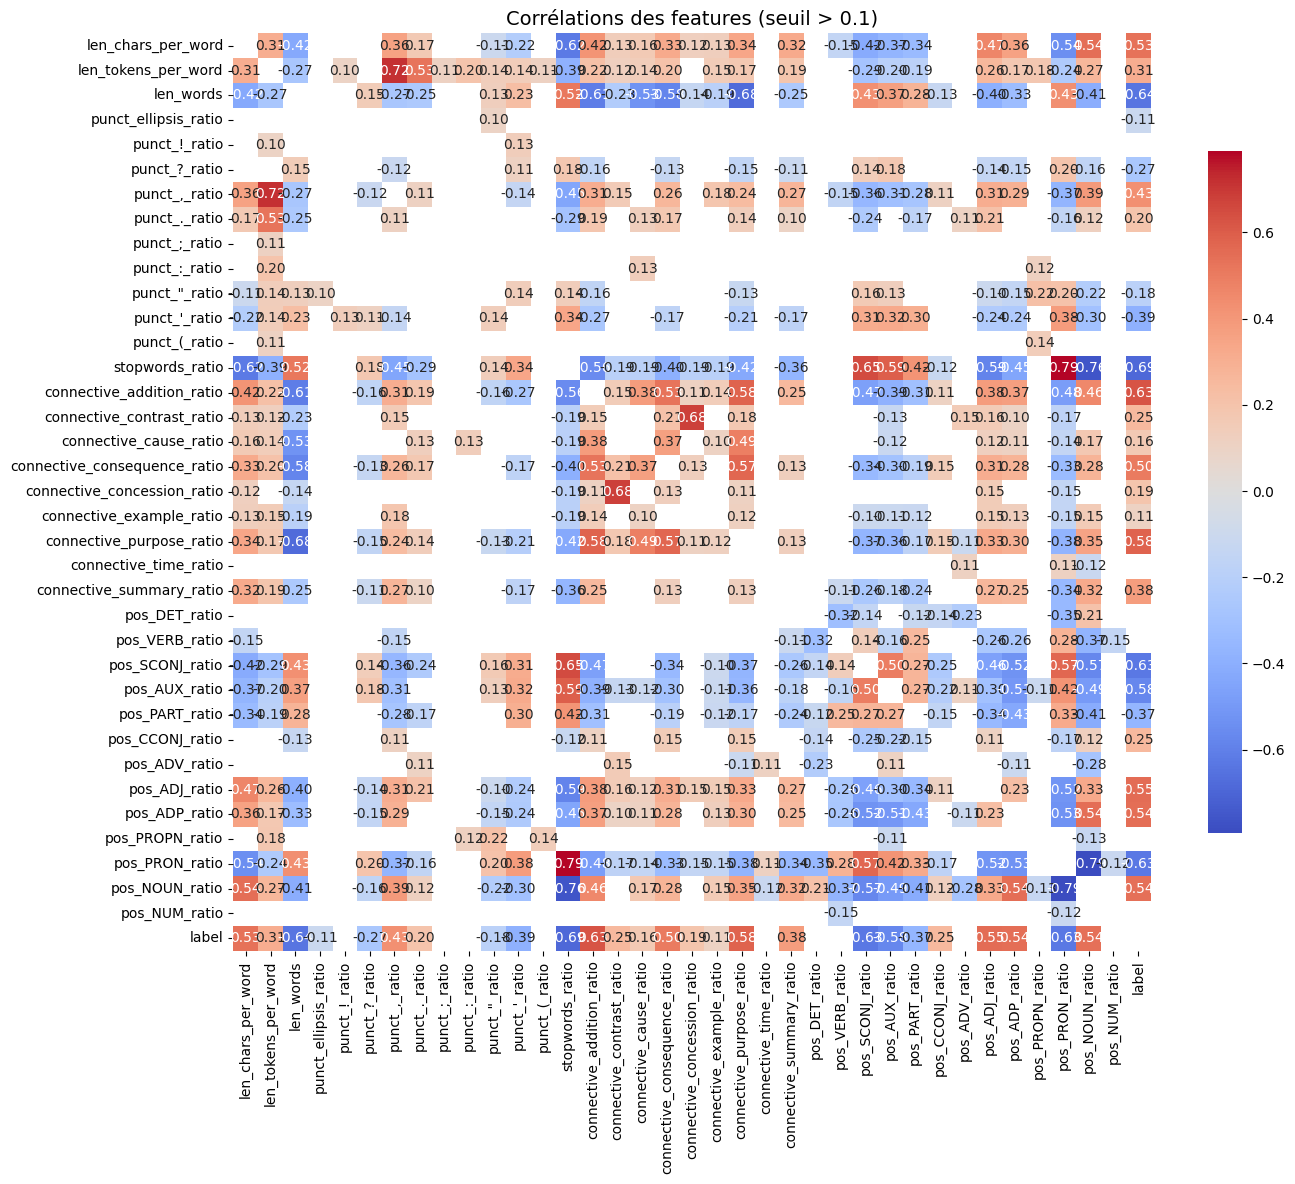

,len_chars_per_word,len_tokens_per_word,len_words,punct_ellipsis_ratio,punct_!_ratio,punct_?_ratio,"punct_,_ratio",punct_._ratio,punct_;_ratio,punct_:_ratio,"punct_""_ratio",punct_'_ratio,punct_(_ratio,stopwords_ratio,connective_addition_ratio,connective_contrast_ratio,connective_cause_ratio,connective_consequence_ratio,connective_concession_ratio,connective_example_ratio,connective_purpose_ratio,connective_time_ratio,connective_summary_ratio,pos_DET_ratio,pos_VERB_ratio,pos_SCONJ_ratio,pos_AUX_ratio,pos_PART_ratio,pos_CCONJ_ratio,pos_ADV_ratio,pos_ADJ_ratio,pos_ADP_ratio,pos_PROPN_ratio,pos_PRON_ratio,pos_NOUN_ratio,pos_NUM_ratio,label
len_chars_per_word,1.000000,0.307165,-0.424213,-0.070344,-0.045380,-0.079206,0.361502,0.165028,-0.027430,-0.026552,-0.105155,-0.224460,-0.029836,-0.621240,0.415138,0.133880,0.161816,0.325356,0.123167,0.132435,0.339493,-0.092505,0.324553,0.038772,-0.148438,-0.422524,-0.371280,-0.337429,0.097773,-0.066013,0.465229,0.356481,0.001767,-0.542689,0.543397,-0.053860,0.532884
len_tokens_per_word,0.307165,1.000000,-0.272048,0.010069,0.102178,0.015778,0.720661,0.527614,0.114431,0.201210,0.135796,0.143865,0.112386,-0.388617,0.217569,0.123462,0.143966,0.204548,0.074216,0.150408,0.172700,0.005578,0.192390,-0.007302,-0.057358,-0.289479,-0.197026,-0.187470,0.011677,0.049009,0.262431,0.173262,0.178101,-0.241006,0.268826,-0.020531,0.309748
len_words,-0.424213,-0.272048,1.000000,0.047629,-0.015444,0.152038,-0.269921,-0.252996,0.054685,-0.047625,0.131257,0.232526,-0.001572,0.516339,-0.610258,-0.228452,-0.525992,-0.581529,-0.135491,-0.189543,-0.677265,-0.002663,-0.254869,-0.037081,0.042327,0.425898,0.365344,0.276545,-0.129825,0.084052,-0.395358,-0.327714,0.008363,0.433594,-0.410062,0.061206,-0.642977
punct_ellipsis_ratio,-0.070344,0.010069,0.047629,1.000000,0.009701,0.022377,-0.009210,-0.027436,0.023280,-0.000725,0.102402,0.063938,0.084725,0.085299,-0.076181,-0.049962,0.010168,-0.043790,-0.055025,-0.009438,-0.064285,0.037019,-0.048315,-0.050957,-0.002471,0.063190,0.074862,-0.005893,0.042000,0.055676,-0.066099,-0.065325,0.022783,0.099716,-0.094194,0.021514,-0.110423
punct_!_ratio,-0.045380,0.102178,-0.015444,0.009701,1.000000,0.080301,-0.013126,-0.013785,-0.008941,0.036135,0.035137,0.134567,0.049114,0.019542,0.007273,-0.051205,0.050796,0.023365,-0.017856,-0.000725,0.048890,0.012439,-0.068743,0.069577,0.051108,-0.029275,-0.022835,0.016141,-0.019935,-0.043635,-0.062874,-0.007578,0.055009,0.048945,-0.014990,0.012324,-0.019915
punct_?_ratio,-0.079206,0.015778,0.152038,0.022377,0.080301,1.000000,-0.115116,0.043636,-0.004923,0.020445,0.067373,0.114189,0.000677,0.178338,-0.159347,-0.058984,-0.067932,-0.132466,-0.034903,-0.002233,-0.152433,0.014475,-0.111695,-0.070673,0.062095,0.140401,0.179172,0.090983,-0.088918,0.007051,-0.143753,-0.149043,0.005772,0.200741,-0.160347,-0.023839,-0.265310
"punct_,_ratio",0.361502,0.720661,-0.269921,-0.009210,-0.013126,-0.115116,1.000000,0.112313,0.085546,0.047307,-0.018082,-0.139462,0.044243,-0.445602,0.312246,0.153351,0.093584,0.264715,0.085495,0.183795,0.242213,-0.006535,0.273906,0.032389,-0.153169,-0.359327,-0.308114,-0.275181,0.114800,0.015711,0.310066,0.291957,0.062830,-0.370963,0.392842,-0.036137,0.430082
punct_._ratio,0.165028,0.527614,-0.252996,-0.027436,-0.013785,0.043636,0.112313,1.000000,-0.091799,0.014218,0.014474,-0.073318,0.015789,-0.291016,0.186080,0.082808,0.128667,0.170943,0.069341,0.061572,0.138292,0.043426,0.102139,-0.047232,0.088213,-0.239051,-0.072902,-0.169072,-0.094670,0.107345,0.210243,0.075431,0.070891,-0.156198,0.120754,-0.090522,0.196778
punct_;_ratio,-0.027430,0.114431,0.054685,0.023280,-0.008941,-0.004923,0.085546,-0.091799,1.000000,0.075878,0.057384,0.043574,0.018527,0.054793,-0.067341,-0.010197,-0.057739,-0.034437,-0.005006,0.003276,-0.048424,-0.012148,0.003361,0.021727,-0.036969,0.003098,0.058443,0.051024,-0.010070,0.031851,-0.033223,-0.029352,0.018529,0.042999,-0.051751,0.026215,-0.043296
punct_:_ratio,-0.026552,0.201210,-0.047625,-0.000725,0.036135,0.020445

In [ ]:
plot_feature_correlation(df_features)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def feature_importance_rf(df, target_col='label', n_estimators=100):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X, y)
    importance = pd.Series(model.feature_importances_, index=X.columns)
    return importance.sort_values(ascending=False)


In [ ]:
feature_importance_rf(df_features)

,0
len_chars_per_word,0.222885
len_words,0.102564
connective_purpose_ratio,0.100982
stopwords_ratio,0.091529
connective_addition_ratio,0.083680
pos_SCONJ_ratio,0.049945
pos_AUX_ratio,0.040903
connective_consequence_ratio,0.038095
pos_PRON_ratio,0.034705
pos_ADP_ratio,0.034361


In [ ]:
from sklearn.ensemble import RandomForestClassifier

def feature_importance_rf(df, target_col='label', n_estimators=100):
    # Conserver uniquement les colonnes numériques (sauf la cible)
    numeric_df = df.select_dtypes(include='number')
    X = numeric_df.drop(columns=[target_col])
    y = df[target_col]

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X, y)

    importance = pd.Series(model.feature_importances_, index=X.columns)
    return importance.sort_values(ascending=False)

# --- Application ---
target_col = 'label'
threshold = 0.01

# Calcul des importances
importance = feature_importance_rf(df, target_col=target_col)

# Séparation : features conservées vs supprimées
kept = importance[importance >= threshold]
removed = importance[importance < threshold]

# Affichage
print(f"\n✅ Features conservées ({len(kept)}):")
print(kept)

print(f"\n❌ Features supprimées ({len(removed)}):")
print(removed)

# Réduction du DataFrame
df_reduced = df[kept.index.tolist() + [target_col]]



✅ Features conservées (16):
len_chars_per_word              0.222885
len_words                       0.102564
connective_purpose_ratio        0.100982
stopwords_ratio                 0.091529
connective_addition_ratio       0.083680
pos_SCONJ_ratio                 0.049945
pos_AUX_ratio                   0.040903
connective_consequence_ratio    0.038095
pos_PRON_ratio                  0.034705
pos_ADP_ratio                   0.034361
punct_,_ratio                   0.026193
pos_ADJ_ratio                   0.024302
punct_._ratio                   0.021423
connective_summary_ratio        0.017483
pos_NOUN_ratio                  0.014466
punct_'_ratio                   0.012296
dtype: float64

❌ Features supprimées (20):
connective_cause_ratio         0.009597
len_tokens_per_word            0.008736
pos_CCONJ_ratio                0.008646
pos_PART_ratio                 0.007529
connective_contrast_ratio      0.006171
connective_example_ratio       0.005909
pos_PROPN_ratio                

In [ ]:
df_exec = pd.DataFrame(execution_log)
print(df_exec)

                               Étape  Durée (s)
0                     Chargement CSV       0.09
1  Tokenisation + longueurs + ratios      48.09
2               Punctuation features       0.11
